In [4]:
print("IMPORT STARTING")
!pip install -q --upgrade tensorflow-io
try:
    import mediapipe as mp
except:
    !pip install -q mediapipe
    import mediapipe as mp

# Machine Learning and Data Science Imports 
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd; pd.options.mode.chained_assignment = None; pd.set_option('display.max_columns', None);
import numpy as np
import sklearn

# Built-In Imports (mostly don't worry about these)
from kaggle_datasets import KaggleDatasets
from collections import Counter
from datetime import datetime
from zipfile import ZipFile
from glob import glob
import Levenshtein
import warnings
import requests
import hashlib
import imageio
import IPython
import sklearn
import urllib
import zipfile
import pickle
import random
import shutil
import string
import json
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

# Visualization Imports 
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
from IPython.display import HTML
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import tifffile as tif
import seaborn as sns
from PIL import Image, ImageEnhance; Image.MAX_IMAGE_PIXELS = 5_000_000_000;
import matplotlib
from matplotlib import animation, rc; rc('animation', html='jshtml')
import plotly
import PIL
import cv2

import plotly.io as pio
print(pio.renderers)

def seed_it_all(seed=7):
    """ To be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

print("\n\n... IMPORTS COMPLETE ...\n")

IMPORT STARTING
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
Renderers configuration
-----------------------
    Default renderer: 'kaggle'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



... IMPORTS COMPLETE ...



In [5]:
df = pd.read_csv('/kaggle/input/gislr-extended-train-dataframe/extended_train.csv')
df.head()

,path,participant_id,sequence_id,sign,start_frame,end_frame,total_frames,face_count,face_nan_count,pose_count,pose_nan_count,left_hand_count,left_hand_nan_count,right_hand_count,right_hand_nan_count,x_min,x_max,y_min,y_max,z_min,z_max
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow,20,42,23,10764,0,759,0,483,483,483,252,-0.031811,1.294350,-2.147826,-0.224151,-2.782624,1.910815
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait,29,39,11,5148,0,363,0,231,231,231,189,-0.017062,1.015931,-2.222732,-0.329273,-2.543970,1.627621
2,/kaggle/input/asl-signs/train_landmark_files/1...,16069,100015657,cloud,103,207,105,49140,0,3465,0,2205,1617,2205,2205,-0.042923,1.197836,-2.591290,-0.248094,-2.838325,1.587503
3,/kaggle/input/asl-signs/train_landmark_files/2...,25571,1000210073,bird,17,28,12,5616,0,396,0,252,252,252,0,-0.129268,1.156573,-2.294936,-0.310272,-3.018237,2.196296
4,/kaggle/input/asl-signs/train_landmark_files/6...,62590,1000240708,owie,22,39,18,8424,0,594,0,378,378,378,0,0.072425,1.165405,-2.264609,-0.405282,-2.970331,1.360011


In [6]:
len(df)

94477

In [7]:
len(df["sign"].unique())

250

In [8]:
df["sign"].value_counts()

listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: sign, Length: 250, dtype: int64

In [9]:
# Helper functions
def get_hand_points(hand):
    """Return x, y lists of normalized spatial coordinates for each finger in the hand dataframe."""
    def __get_hand_ax(_axis):
        return [np.nan_to_num(_x) for _x in 
            [hand.iloc[i][_axis] for i in range(5)]+\
            [[hand.iloc[i][_axis] for i in range(j, j+4)] for j in range(5, 21, 4)]+\
            [hand.iloc[i][_axis] for i in special_pts]]
    special_pts = [0, 5, 9, 13, 17, 0]
    return [__get_hand_ax(_ax) for _ax in ['x','y','z']]

def get_pose_points(pose):
    """
    Extracts x and y coordinates from the provided dataframe for pose landmarks.

    Args:
        pose (pandas.DataFrame): Dataframe containing pose landmarks with columns ['x', 'y', 'z', 'visibility', 'presence'].

    Returns:
        tuple: Two lists of x and y coordinates, respectively.

    """
    def __get_pose_ax(_axis):
        return [np.nan_to_num(_x) for _x in [
            [pose.iloc[i][_axis] for i in [8, 6, 5, 4, 0, 1, 2, 3, 7]], 
            [pose.iloc[i][_axis] for i in [10, 9]], 
            [pose.iloc[i][_axis] for i in [22, 16, 20, 18, 16, 14, 12, 11, 13, 15, 17, 19, 15, 21]], 
            [pose.iloc[i][_axis] for i in [12, 24, 26, 28, 30, 32, 28]], 
            [pose.iloc[i][_axis] for i in [11, 23, 25, 27, 29, 31, 27]], 
            [pose.iloc[i][_axis] for i in [24, 23]]
        ]]
    return [__get_pose_ax(_ax) for _ax in ['x','y','z']]


def animation_frame(f, event_df, ax, ax_pad=0.2, style="full", 
                    face_color="spring", pose_color="autumn", lh_color="winter", rh_color="summer"):
    """
    Function called by FuncAnimation to animate the plot with the provided frame.

    Args:
        f (int): The current frame number.

    Returns:
        None.
    """
    
    face_color = plt.cm.get_cmap(face_color)
    pose_color = plt.cm.get_cmap(pose_color)
    rh_color = plt.cm.get_cmap(rh_color)
    lh_color = plt.cm.get_cmap(lh_color)
    
    sign_df = event_df.copy()
    
    # Clear axis and fix the axis
    ax.clear()
    if style=="full":
        xmin = sign_df['x'].min() - ax_pad
        xmax = sign_df['x'].max() + ax_pad
        ymin = sign_df['y'].min() - ax_pad
        ymax = sign_df['y'].max() + ax_pad
    elif style=="hands":
        xmin = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['x'].min() - ax_pad
        xmax = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['x'].max() + ax_pad
        ymin = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['y'].min() - ax_pad
        ymax = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['y'].max() + ax_pad
    else:
        xmin = sign_df[sign_df.type==style]['x'].min() - ax_pad
        xmax = sign_df[sign_df.type==style]['x'].max() + ax_pad
        ymin = sign_df[sign_df.type==style]['y'].min() - ax_pad
        ymax = sign_df[sign_df.type==style]['y'].max() + ax_pad
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis(False) # Remove the axis lines
    
    # Normalize depth
    zmin, zmax = sign_df['z'].min(), sign_df['z'].max()
    sign_df['z'] = (sign_df['z']-zmin)/(zmax-zmin)
    
    # Get data for current frame
    frame = sign_df[sign_df.frame==f]
    
    # Left Hand
    if style.lower() in ["left_hand", "hands", "full"]:
        left = frame[frame.type=='left_hand']
        lx, ly, lz = get_hand_points(left)
        for i in range(len(lx)):
            if type(lx[i])!=np.float64:
                lh_clr = [lh_color(((np.abs(_x)+np.abs(_y))/2)) for _x, _y in zip(lx[i], ly[i])]
                lh_clr = tuple(sum(_x)/len(_x) for _x in zip(*lh_clr))
            else: 
                lh_clr = lh_color(((np.abs(lx[i])+np.abs(ly[i]))/2))
            ax.plot(lx[i], ly[i], color=lh_clr, alpha=lz[i].mean())
    
    # Right Hand
    if style.lower() in ["right_hand", "hands", "full"]:
        right = frame[frame.type=='right_hand']
        rx, ry, rz = get_hand_points(right)
        for i in range(len(rx)):
            if type(rx[i])!=np.float64:
                rh_clr = [rh_color((np.abs(_x)+np.abs(_y))/2) for _x, _y in zip(rx[i], ry[i])] 
                rh_clr = tuple(sum(_x)/len(_x) for _x in zip(*rh_clr))
            else:
                rh_clr = rh_color(((np.abs(rx[i])+np.abs(ry[i]))/2))
            ax.plot(rx[i], ry[i], color=rh_clr, alpha=rz[i].mean())
    
    # Pose
    if style.lower() in ["pose", "full"]:
        pose = frame[frame.type=='pose']
        px, py, pz = get_pose_points(pose)
        for i in range(len(px)):
            if type(px[i])!=np.float64:
                pose_clr = [pose_color(((np.abs(_x)+np.abs(_y))/2)) for _x, _y in zip(px[i], py[i])]
                pose_clr = tuple(sum(_x)/len(_x) for _x in zip(*pose_clr))
            else: 
                pose_clr = pose_color(((np.abs(px[i])+np.abs(py[i]))/2))
            ax.plot(px[i], py[i], color=pose_clr, alpha=pz[i].mean())
        
    if style.lower() in ["face", "full"]:
        face = frame[frame.type=='face'][['x', 'y', 'z']].values
        fx, fy, fz = face[:,0], face[:,1], face[:,2]
        for i in range(len(fx)):
            ax.plot(fx[i], fy[i], '.', color=pose_color(fz[i]), alpha=fz[i])
    
    # Use this so we don't get an extra return
    plt.close()
    
    
def plot_event(event_df, style="full"):
    # Create figure and animation
    fig, ax = plt.subplots()
    l, = ax.plot([], [])
    animation = FuncAnimation(fig, func=lambda x: animation_frame(x, event_df, ax, style=style), 
                              frames=event_df["frame"].unique())
    
    # Display animation as HTML5 video
    return HTML(animation.to_html5_video())

In [12]:
def flatten_l_o_l(nested_list):
    """Flatten a list of lists into a single list.

    Args:
        nested_list (list): 
            – A list of lists (or iterables) to be flattened.

    Returns:
        list: A flattened list containing all items from the input list of lists.
    """
    return [item for sublist in nested_list for item in sublist]


def print_ln(symbol="-", line_len=110, newline_before=False, newline_after=False):
    """Print a horizontal line of a specified length and symbol.

    Args:
        symbol (str, optional): 
            – The symbol to use for the horizontal line
        line_len (int, optional): 
            – The length of the horizontal line in characters
        newline_before (bool, optional): 
            – Whether to print a newline character before the line
        newline_after (bool, optional): 
            – Whether to print a newline character after the line
    """
    if newline_before: print();
    print(symbol * line_len)
    if newline_after: print();
        
        
def read_json_file(file_path):
    """Read a JSON file and parse it into a Python object.

    Args:
        file_path (str): The path to the JSON file to read.

    Returns:
        dict: A dictionary object representing the JSON data.
        
    Raises:
        FileNotFoundError: If the specified file path does not exist.
        ValueError: If the specified file path does not contain valid JSON data.
    """
    try:
        # Open the file and load the JSON data into a Python object
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        return json_data
    except FileNotFoundError:
        # Raise an error if the file path does not exist
        raise FileNotFoundError(f"File not found: {file_path}")
    except ValueError:
        # Raise an error if the file does not contain valid JSON data
        raise ValueError(f"Invalid JSON data in file: {file_path}")
        
def get_sign_df(pq_path, invert_y=True):
    sign_df = pd.read_parquet(pq_path)
    print("parquet file\n", sign_df)
    
    # y value is inverted (Thanks @danielpeshkov)
    print("non-inverted_y\n",sign_df["y"])
    if invert_y: sign_df["y"] *= -1 
    print("inverted_y\n",sign_df["y"])    
    return sign_df


ROWS_PER_FRAME = 543  # number of landmarks per frame
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [13]:
# Define the path to the root data directory
DATA_DIR         = "/kaggle/input/asl-signs"
EXTEND_TRAIN_DIR = "/kaggle/input/gislr-extended-train-dataframe" 

print("\n\n... LOAD TRAIN DATAFRAME FROM CSV FILE ...\n")

LOAD_EXTENDED = True
if LOAD_EXTENDED and os.path.isfile(os.path.join(EXTEND_TRAIN_DIR, "extended_train.csv")):
    train_df = pd.read_csv(os.path.join(EXTEND_TRAIN_DIR, "extended_train.csv"))
else:
    train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
    train_df["path"] = DATA_DIR+"/"+train_df["path"]
display(train_df)

print("\n\n... LOAD SIGN TO PREDICTION INDEX MAP FROM JSON FILE ...\n")
s2p_map = {k.lower():v for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
print("s2p_map", s2p_map, end = "\n")
p2s_map = {v:k for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)


DEMO_ROW = 200
print(f"\n\n... DEMO SIGN/EVENT DATAFRAME FOR ROW {DEMO_ROW} - SIGN={train_df.iloc[DEMO_ROW]['sign']} ...\n")

demo_sign_df = get_sign_df(train_df.iloc[DEMO_ROW]["path"])

display(demo_sign_df)

plot_event(demo_sign_df)



... LOAD TRAIN DATAFRAME FROM CSV FILE ...



,path,participant_id,sequence_id,sign,start_frame,end_frame,total_frames,face_count,face_nan_count,pose_count,pose_nan_count,left_hand_count,left_hand_nan_count,right_hand_count,right_hand_nan_count,x_min,x_max,y_min,y_max,z_min,z_max
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow,20,42,23,10764,0,759,0,483,483,483,252,-0.031811,1.294350,-2.147826,-0.224151,-2.782624,1.910815
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait,29,39,11,5148,0,363,0,231,231,231,189,-0.017062,1.015931,-2.222732,-0.329273,-2.543970,1.627621
2,/kaggle/input/asl-signs/train_landmark_files/1...,16069,100015657,cloud,103,207,105,49140,0,3465,0,2205,1617,2205,2205,-0.042923,1.197836,-2.591290,-0.248094,-2.838325,1.587503
3,/kaggle/input/asl-signs/train_landmark_files/2...,25571,1000210073,bird,17,28,12,5616,0,396,0,252,252,252,0,-0.129268,1.156573,-2.294936,-0.310272,-3.018237,2.196296
4,/kaggle/input/asl-signs/train_landmark_files/6...,62590,1000240708,owie,22,39,18,8424,0,594,0,378,378,378,0,0.072425,1.165405,-2.264609,-0.405282,-2.970331,1.360011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,/kaggle/input/asl-signs/train_landmark_files/5...,53618,999786174,white,64,112,49,22932,0,1617,0,1029,1029,1029,546,0.031721,1.183957,-2.561170,-0.297828,-3.287074,2.400607
94473,/kaggle/input/asl-signs/train_landmark_files/2...,26734,999799849,have,36,41,6,2808,0,198,0,126,126,126,84,-0.149159,1.310044,-2.170514,-0.177696,-2.678213,1.494088
94474,/kaggle/input/asl-signs/train_landmark_files/2...,25571,999833418,flower,1,37,37,17316,0,1221,0,777,777,777,294,0.057847,0.977379,-2.460778,-0.223186,-3.220553,2.083376
94475,/kaggle/input/asl-signs/train_landmark_files/2...,29302,999895257,room,9,42,34,15912,0,1122,0,714,714,714,588,-0.045806,0.985802,-2.081611,-0.325751,-2.036529,2.350194




... LOAD SIGN TO PREDICTION INDEX MAP FROM JSON FILE ...

s2p_map {'tv': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face

,frame,row_id,type,landmark_index,x,y,z
0,30,30-face-0,face,0,0.428286,-0.374841,-0.054664
1,30,30-face-1,face,1,0.429916,-0.345540,-0.055823
2,30,30-face-2,face,2,0.429739,-0.363223,-0.039653
3,30,30-face-3,face,3,0.419398,-0.325092,-0.025128
4,30,30-face-4,face,4,0.429804,-0.336577,-0.054424
...,...,...,...,...,...,...,...
3796,36,36-right_hand-16,right_hand,16,0.206294,-0.466136,-0.128646
3797,36,36-right_hand-17,right_hand,17,0.055602,-0.324901,-0.117464
3798,36,36-right_hand-18,right_hand,18,0.112708,-0.388596,-0.143662
3799,36,36-right_hand-19,right_hand,19,0.138833,-0.429676,-0.133067


In [14]:
# import dataset converted to numpy arrays
train_x    = np.load("/kaggle/input/gislr-feature-data/feature_data.npy").astype(np.float32)
train_y    = np.load("/kaggle/input/gislr-feature-data/feature_labels.npy").astype(np.uint8)
BATCH_SIZE = 64

N_TOTAL = train_x.shape[0]
print("N_TOTAL", N_TOTAL)
VAL_PCT = 0.1
N_VAL   = int(N_TOTAL*VAL_PCT)
N_TRAIN = N_TOTAL-N_VAL

random_idxs = random.sample(range(N_TOTAL), N_TOTAL)
train_idxs, val_idxs = np.array(random_idxs[:N_TRAIN]), np.array(random_idxs[N_TRAIN:])

val_x, val_y = train_x[val_idxs], train_y[val_idxs]
train_x, train_y = train_x[train_idxs], train_y[train_idxs]

N_TOTAL 94477


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3258)]            0         
                                                                 
 dense_12 (Dense)            (None, 512)               1668608   
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 512)               0         
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                           

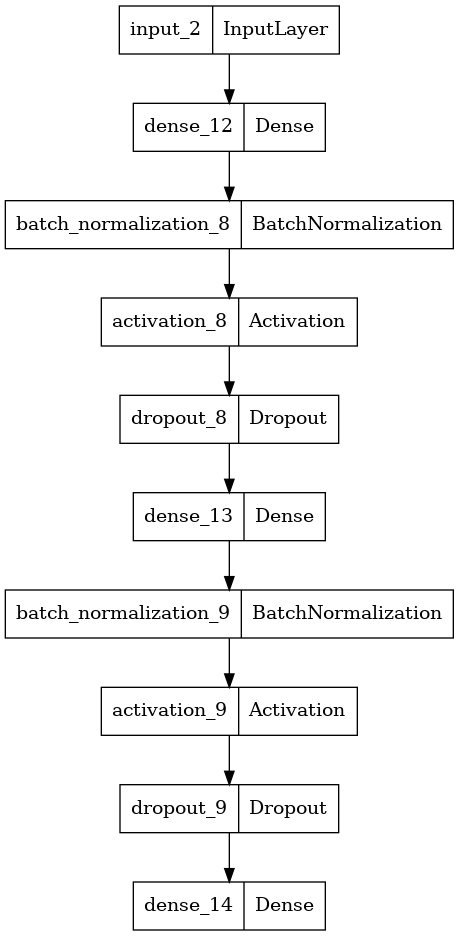

In [17]:
"""
fully connected neural network model
with configurable number of blocks of fully connected layers.
"""
def fc_block(inputs, output_channels, dropout=0.2):
    x = tf.keras.layers.Dense(output_channels)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x

def get_model(n_labels=250, init_fc=512, n_blocks=2, _dropout_1=0.2, _dropout_2=0.6, flat_frame_len=3258):
    _inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
    x = _inputs
    
    # Define layers
    for i in range(n_blocks):
        x = fc_block(
            x, output_channels=init_fc//(2**i), 
            dropout=_dropout_1 if (1+i)!=n_blocks else _dropout_2
        )
    
    # Define output layer
    _outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)
    
    # Build the model
    model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
    return model

model = get_model()
model.compile(tf.keras.optimizers.Adam(0.000333), "sparse_categorical_crossentropy", metrics="acc")
model.summary()

tf.keras.utils.plot_model(model)

In [18]:
# Create a new directory called "models"
!mkdir models

# Define a list of two callback functions to monitor training progress
cb_list = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.8, verbose=1)
]

# Train the model on the training data, monitor the validation data, and use the defined callbacks
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=100, callbacks=cb_list, batch_size=BATCH_SIZE)

# Save the trained model
model.save("./models/asl_model")


Epoch 1/100
1329/1329 [==============================] - 34s 24ms/step - loss: 5.3680 - acc: 0.0150 - val_loss: 5.1853 - val_acc: 0.0142 - lr: 3.3300e-04
Epoch 2/100
1329/1329 [==============================] - 32s 24ms/step - loss: 4.5914 - acc: 0.0603 - val_loss: 4.8161 - val_acc: 0.0416 - lr: 3.3300e-04
Epoch 3/100
1329/1329 [==============================] - 32s 24ms/step - loss: 3.9928 - acc: 0.1233 - val_loss: 4.6022 - val_acc: 0.0547 - lr: 3.3300e-04
Epoch 4/100
1329/1329 [==============================] - 32s 24ms/step - loss: 3.6419 - acc: 0.1721 - val_loss: 4.3766 - val_acc: 0.0849 - lr: 3.3300e-04
Epoch 5/100
1329/1329 [==============================] - 32s 24ms/step - loss: 3.4261 - acc: 0.2109 - val_loss: 4.2536 - val_acc: 0.0987 - lr: 3.3300e-04
Epoch 6/100
1329/1329 [==============================] - 32s 24ms/step - loss: 3.2598 - acc: 0.2403 - val_loss: 4.0506 - val_acc: 0.1227 - lr: 3.3300e-04
Epoch 7/100
1329/1329 [==============================] - 33s 25ms/step - los

In [19]:
model.evaluate(val_x, val_y)
for x,y in zip(val_x[:10], val_y[:10]):
    print(f"PRED: {decoder(np.argmax(model.predict(tf.expand_dims(x, axis=0), verbose=0), axis=-1)[0]):<20} – GT: {decoder(y)}")

296/296 [==============================] - 1s 4ms/step - loss: 1.5143 - acc: 0.6343
PRED: all                  – GT: all
PRED: better               – GT: better
PRED: hen                  – GT: bug
PRED: toy                  – GT: horse
PRED: animal               – GT: animal
PRED: ear                  – GT: ear
PRED: airplane             – GT: airplane
PRED: weus                 – GT: arm
PRED: potty                – GT: beside
PRED: pretend              – GT: pretend


In [20]:
class PrepInputs(tf.keras.layers.Layer):
    def __init__(self, face_idx_range=(0, 468), lh_idx_range=(468, 489), 
                 pose_idx_range=(489, 522), rh_idx_range=(522, 543)):
        super(PrepInputs, self).__init__()
        self.idx_ranges = [face_idx_range, lh_idx_range, pose_idx_range, rh_idx_range]
        self.flat_feat_lens = [3*(_range[1]-_range[0]) for _range in self.idx_ranges]
    
    def call(self, x_in):
        
        # Split the single vector into 4
        xs = [x_in[:, _range[0]:_range[1], :] for _range in self.idx_ranges]
        
        # Reshape based on specific number of keypoints
        xs = [tf.reshape(_x, (-1, flat_feat_len)) for _x, flat_feat_len in zip(xs, self.flat_feat_lens)]
        
        # Drop empty rows - Empty rows are present in 
        #   --> pose, lh, rh
        #   --> so we don't have to for face
        xs[1:] = [
            tf.boolean_mask(_x, tf.reduce_all(tf.logical_not(tf.math.is_nan(_x)), axis=1), axis=0)
            for _x in xs[1:]
        ]
        
        # Get means and stds
        x_means = [tf.math.reduce_mean(_x, axis=0) for _x in xs]
        x_stds  = [tf.math.reduce_std(_x,  axis=0) for _x in xs]
        
        x_out = tf.concat([*x_means, *x_stds], axis=0)
        x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
        return tf.expand_dims(x_out, axis=0)
    
PrepInputs()(load_relevant_data_subset(train_df.path[0]))


<tf.Tensor: shape=(1, 3258), dtype=float32, numpy=
array([[ 0.52765715,  0.37799075, -0.03728105, ...,  0.15039368,
         0.0695638 ,  0.04059875]], dtype=float32)>

In [25]:

class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ISLR model 
    """

    def __init__(self, islr_model):
        """
        Initializes the TFLiteModel with the specified preprocessing model and ISLR model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = PrepInputs()
        self.islr_model   = islr_model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        outputs = self.islr_model(x)[0, :]

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

tflite_keras_model = TFLiteModel(islr_model=model)
demo_output = tflite_keras_model(load_relevant_data_subset(train_df.path[2]))["outputs"]
decoder(np.argmax(demo_output.numpy(), axis=-1))

'cloud'

In [29]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/models/model.tflite', 'wb') as f:
    f.write(tflite_model)
# !zip submission.zip /kaggle/working/models/model.tflite

# !pip install tflite-runtime
# import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/working/models/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
# if REQUIRED_SIGNATURE not in found_signatures:
#     raise KernelEvalException('Required input signature not found.')
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=load_relevant_data_subset(train_df.path[0]))
sign = np.argmax(output["outputs"])

print("Predicted sign: ", decoder(sign))
print("Ground Truth  : ", train_df.sign[0])

Predicted sign:  blow
Ground Truth  :  blow
